# Training an Equinox MLP on Spiral Data

This notebook demonstrates how to train a three-layer MLP (using Equinox) to classify the spiral dataset generated by `spiral_data.py`. The training loop uses JAX and Equinox, and the model is compiled with `eqx.filter_jit` for efficiency.

In [1]:
import jax
import jax.numpy as jnp
import equinox as eqx
import matplotlib.pyplot as plt
from spiral_data import generate_spiral_data
from mlp import MLP

import optax

In [2]:
# Generate spiral dataset
X, y = generate_spiral_data(points_per_class=100, num_classes=3, noise=0.2)
num_classes = 3
# One-hot encode labels
Y = jax.nn.one_hot(y, num_classes)
print(f"X shape: {X.shape}, Y shape: {Y.shape}")

X shape: (300, 2), Y shape: (300, 3)


In [3]:
# Loss function and accuracy metric

def compute_loss(model, x, y):
    """Complete this function to return the cross-entropy loss.""" 
    pred_y = jax.vmap(model)(x)  
    return -jax.numpy.mean(y * jax.numpy.log(pred_y))


def compute_accuracy(model, x, y):
    """Complete this function to return the accuracy."""
    def eval_single(model, x, y):
        pred_y = model(x)
        return jnp.argmax(pred_y).astype(int) == jnp.argmax(y).astype(int)

    correct = jax.vmap(eval_single, in_axes=(None,0,0))(model, x, y)
    return jnp.sum(correct) / x.shape[0] * 100


In [4]:
# Training step (JIT compiled)
@eqx.filter_jit
def train_step(model, x, y, opt_state, optimizer):
    def loss_fn(model):
        return compute_loss(model, x, y)
    loss, grads = eqx.filter_value_and_grad(loss_fn)(model)
    updates, opt_state = optimizer.update(grads, opt_state, eqx.filter(model, eqx.is_array))
    model = eqx.apply_updates(model, updates)
    return model, opt_state

In [5]:
# Initialize model and optimizer
key = jax.random.PRNGKey(0)
model = MLP(key) # Instantiate your MLP model here
optimizer = optax.adam(learning_rate=.4) # Choose your optimizer and learning_rate.
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

In [6]:
# Training loop
num_epochs = 200# Set the number of epochs
for epoch in range(num_epochs):
    model, opt_state = train_step(model, X, Y, opt_state, optimizer)
    if (epoch + 1) % 10 == 0:
        loss = compute_loss(model, X, Y)
        acc = compute_accuracy(model, X, Y)
        print(f"Epoch {epoch+1}: Loss={loss:.4f}, Accuracy={acc:.4f}")

Epoch 10: Loss=0.7136, Accuracy=33.3333
Epoch 20: Loss=0.3706, Accuracy=50.3333
Epoch 30: Loss=0.2776, Accuracy=45.6667
Epoch 40: Loss=0.2360, Accuracy=54.6667
Epoch 50: Loss=0.2249, Accuracy=50.3333
Epoch 60: Loss=0.2156, Accuracy=58.0000
Epoch 70: Loss=0.2009, Accuracy=53.6667
Epoch 80: Loss=0.1664, Accuracy=70.0000
Epoch 90: Loss=0.1119, Accuracy=83.3333
Epoch 100: Loss=0.0761, Accuracy=89.6667
Epoch 110: Loss=0.0541, Accuracy=94.3333
Epoch 120: Loss=0.0412, Accuracy=96.3333
Epoch 130: Loss=0.0339, Accuracy=97.3333
Epoch 140: Loss=0.0288, Accuracy=98.0000
Epoch 150: Loss=0.0246, Accuracy=98.0000
Epoch 160: Loss=0.0214, Accuracy=98.3333
Epoch 170: Loss=0.0189, Accuracy=99.0000
Epoch 180: Loss=0.0170, Accuracy=99.3333
Epoch 190: Loss=0.0155, Accuracy=99.3333
Epoch 200: Loss=0.0143, Accuracy=99.3333


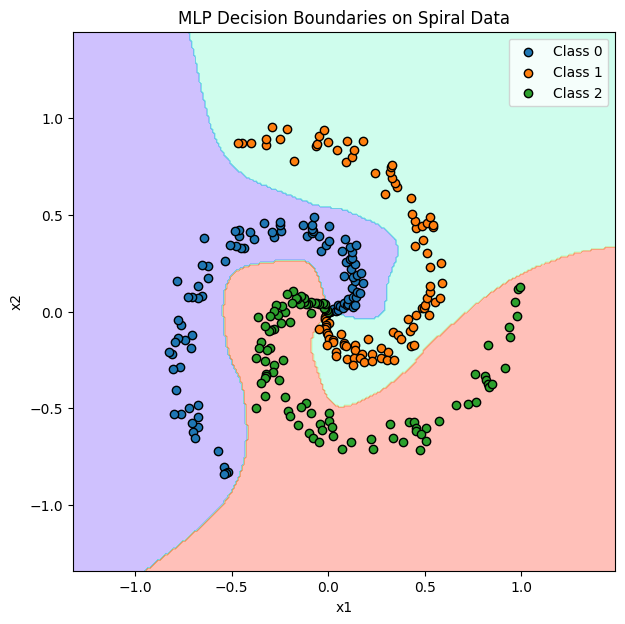

In [7]:
# Visualize decision boundaries and predictions
h = 0.01
x_min, x_max = float(jnp.min(X[:, 0])) - 0.5, float(jnp.max(X[:, 0])) + 0.5
y_min, y_max = float(jnp.min(X[:, 1])) - 0.5, float(jnp.max(X[:, 1])) + 0.5
xx, yy = jnp.meshgrid(jnp.arange(x_min, x_max, h), jnp.arange(y_min, y_max, h))
grid = jnp.c_[xx.ravel(), yy.ravel()]
logits = jax.vmap(model)(grid)
preds = jnp.argmax(logits, axis=1)
preds = preds.reshape(xx.shape)
plt.figure(figsize=(7, 7))
plt.contourf(xx, yy, preds, alpha=0.3, cmap=plt.cm.rainbow)
for class_number in range(num_classes):
    plt.scatter(X[y == class_number, 0], X[y == class_number, 1], label=f"Class {class_number}", edgecolor='k')
plt.legend()
plt.title("MLP Decision Boundaries on Spiral Data")
plt.xlabel("x1")
plt.ylabel("x2")
plt.axis("equal")
plt.show()
